# Notebook of the Model Fine-Tuning with Huggingface Trainer

In [1]:
%%capture
!pip install transformers
!pip install datasets
!pip install torchvision
!pip install wandb
!pip install ipynb
!pip install s3fs
!pip install nvidia-ml-py3
!pip install sentencepiece

## Best Optuna Hyperparameters:
    - BestRun(run_id='17', objective=0.8041917886879126, hyperparameters={'num_train_epochs': 3, 'learning_rate': 4.5132496745073475e-05, 'warmup_steps': 0.3, 'weight_decay': 0.022282597381446483, 'per_device_train_batch_size': 8})
  - wie angegeben: 0.758063
  - mit 7 Epochs anstatt 3: 0.784619
  - mit 5 Epochs anstatt 3: 0.818966
  - mit Batch 16 statt 8:  0.814296
  - mit Batch 16 statt 8 und 6 Epochs: 0.770077
  - mit Batch 16 statt 8 und 4 Epochs:0.818253
  - mit Batch 16 statt 8 und 5 Epochs:0.814296
        
        

## Best WANDB Hyperparameters:
   - Batch Size: 4, Learning_Rate: 0.00002091, Epochs: 5, Warum_up: 0.3, Weight_Decay: 0.4
   - wie angegeben: 0.789587
   - mit Batch 8 statt 4: 0.801988
   - mit Batch 16 statt 4: 0.799205
   - mit Batch 8 statt 4 und 7 Epochs: 0.804964
   - hier normale Werte verwenden und Argumentieren, dass die Parameter von Optuna besser geklappt haben


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import EarlyStoppingCallback
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report 
from transformers import get_scheduler
from transformers import AdamW
import shutil
import pandas as pd
import json
import s3fs
import os
import torch
from ipynb.fs.full.eval_metrics import *
hello()

Hello World!


In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

torch.cuda.is_available()

# Opening Credentials-JSON file
with open('../credentials.json', 'r') as openfile:
 
    # Reading from json file
    json_object = json.load(openfile)
    key = json_object["key"]
    secret = json_object["secret_key"]
    bucket_name = json_object["bucket_name"]

s3 = s3fs.S3FileSystem(anon=False,key=key,secret=secret)

In [5]:
ansatz = "ALLGERM_deepset_gbert_base"
model_name = "deepset/gbert-base"


# Von BERT Models:
learning_rate = 4.5132496745073475e-05
epochs = 5
weight_decay = 0.022282597381446483
warmup = 0.3
batch_size = 8

train_test_number = [1,2,3,4,5]
# Specify Approach with train_file_name and test_file_name
#train_file_name = "train.csv"
#test_file_name = "test.csv"
#train_file_name = "train_plus_neutral_germeval.csv"
#test_file_name = "test_plus_neutral_germeval.csv"
#train_file_name = "preprocessed_train_plus_neutral_germeval.csv"
#test_file_name = "preprocessed_test_plus_neutral_germeval.csv"
train_file_name = "train_plus_all_germeval.csv"
test_file_name = "test_plus_all_germeval.csv"

# Listing all used models
#Hate-speech-CNERG/dehatebert-mono-german                  ###DONE
#shahrukhx01/gbert-hasoc-german-2019                       ###DONE
#bert-base-multilingual-cased                              ###DONE
#EIStakovskii/german_toxicity_classifier_plus_v2           ###DONE
#"bert-base-german-cased"                                  ###DONE
#"dbmdz/bert-base-german-cased"                            ###DONE --> Run 4 irgendwie voll schlecht
#"bert-base-german-dbmdz-uncased"                          ###DONE
#"distilbert-base-german-cased"                            ###DONE
#"german-nlp-group/electra-base-german-uncased"            ###DONE
#"bert-base-multilingual-uncased"                          ###DONE
#"xlm-roberta-base"                                        ###DONE
#T-Systems-onsite/cross-en-de-roberta-sentence-transformer ###DONE
#cardiffnlp/twitter-xlm-roberta-base                       ###DONE
# https://huggingface.co/cardiffnlp/twitter-roberta-base-offensive evtl für Translation Approach

Fold Number: 1
                                                text  labels
0  @Bundeskanzler @OlafScholz Deutschland muss ha...       0
1  @ben_brechtken @OlafScholz Benny, du bist leid...       1
10836
2709
Train Verteilung: 0    6901
1    3935
Name: labels, dtype: int64
Test Verteilung: 0    1725
1     984
Name: labels, dtype: int64


Some weights of the model checkpoint at deepset/gbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8668
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5420
  Number of trainable parameters = 109929218
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: varrukta-mongo (mox). Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.422600,0.412791,0.825646,0.822025,0.796120,0.805483
2,0.310200,0.637444,0.821033,0.830909,0.779390,0.793791
3,0.199600,0.841056,0.838100,0.830680,0.816438,0.822378
4,0.071900,1.154563,0.831642,0.821452,0.812898,0.816699
5,0.020200,1.257715,0.826107,0.815866,0.805903,0.810235


***** Running Evaluation *****
  Num examples = 2168
  Batch size = 8
Saving model checkpoint to res/checkpoint-1084
Configuration saved in res/checkpoint-1084/config.json
Model weights saved in res/checkpoint-1084/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2168
  Batch size = 8
Saving model checkpoint to res/checkpoint-2168
Configuration saved in res/checkpoint-2168/config.json
Model weights saved in res/checkpoint-2168/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2168
  Batch size = 8
Saving model checkpoint to res/checkpoint-3252
Configuration saved in res/checkpoint-3252/config.json
Model weights saved in res/checkpoint-3252/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2168
  Batch size = 8
Saving model checkpoint to res/checkpoint-4336
Configuration saved in res/checkpoint-4336/config.json
Model weights saved in res/checkpoint-4336/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2168
  Batch size = 

Saving Best Model


Model weights saved in ALLGERM_deepset_gbert_base_best_model/pytorch_model.bin
loading configuration file ALLGERM_deepset_gbert_base_best_model/config.json
Model config BertConfig {
  "_name_or_path": "ALLGERM_deepset_gbert_base_best_model",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31102
}

loading weights file ALLGERM_deepset_gbert_base_best_model/pytorch_model.bin
All model checkpoint weights w

                              1
0                              
acc                    0.825028
bal_acc                0.800400
mcc                    0.615547
f1_macro               0.806562
f1_micro               0.825028
f1_weighted            0.822910
precision_macro        0.815327
precision_micro        0.825028
precision_weighted     0.823031
recall_macro           0.800400
recall_micro           0.825028
recall_weighted        0.825028
precision_class_0      0.843493
precision_class_1      0.787162
recall_class_0         0.890435
recall_class_1         0.710366
f1_score_class_0       0.866328
f1_score_class_1       0.746795
sample_class_0      1725.000000
sample_class_1       984.000000
Finished Fold Number: 1
Fold Number: 2
                                                text  labels
0  Wenn es ums Geld aus Gas-, Öl- &amp; Kohlegesc...       1
1  @JanSchipmann @emiliafester Sicher ?... ich em...       1
10836
2709
Train Verteilung: 0    6901
1    3935
Name: labels, dtype: int6

loading configuration file config.json from cache at /home/jovyan/.cache/huggingface/hub/models--deepset--gbert-base/snapshots/4a45e506eccc3405ed2e2a0502995d3f7e483509/config.json
Model config BertConfig {
  "_name_or_path": "deepset/gbert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31102
}

loading file vocab.txt from cache at /home/jovyan/.cache/huggingface/hub/models--deepset--gbert-base/snapshots/4a45e506eccc3405ed2e2a0502995d3f7e483509/vocab.txt
loading file tokenizer.json fro

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.426500,0.445629,0.799354,0.789504,0.763447,0.772652
2,0.426600,0.662730,0.816882,0.800548,0.803998,0.802182
3,0.145600,0.886688,0.813192,0.797628,0.794329,0.795903
4,0.072400,1.214054,0.817804,0.810140,0.785193,0.794434
5,0.010900,1.352349,0.816882,0.805584,0.789284,0.795908


***** Running Evaluation *****
  Num examples = 2168
  Batch size = 8
Saving model checkpoint to res/checkpoint-1084
Configuration saved in res/checkpoint-1084/config.json
Model weights saved in res/checkpoint-1084/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2168
  Batch size = 8
Saving model checkpoint to res/checkpoint-2168
Configuration saved in res/checkpoint-2168/config.json
Model weights saved in res/checkpoint-2168/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2168
  Batch size = 8
Saving model checkpoint to res/checkpoint-3252
Configuration saved in res/checkpoint-3252/config.json
Model weights saved in res/checkpoint-3252/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2168
  Batch size = 8
Saving model checkpoint to res/checkpoint-4336
Configuration saved in res/checkpoint-4336/config.json
Model weights saved in res/checkpoint-4336/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2168
  Batch size = 

Saving Best Model


Model weights saved in ALLGERM_deepset_gbert_base_best_model/pytorch_model.bin
loading configuration file ALLGERM_deepset_gbert_base_best_model/config.json
Model config BertConfig {
  "_name_or_path": "ALLGERM_deepset_gbert_base_best_model",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31102
}

loading weights file ALLGERM_deepset_gbert_base_best_model/pytorch_model.bin
All model checkpoint weights w

                              1
0                              
acc                    0.825766
bal_acc                0.807092
mcc                    0.620221
f1_macro               0.809883
f1_micro               0.825766
f1_weighted            0.824914
precision_macro        0.813159
precision_micro        0.825766
precision_weighted     0.824482
recall_macro           0.807092
recall_micro           0.825766
recall_weighted        0.825766
precision_class_0      0.854556
precision_class_1      0.771762
recall_class_0         0.875362
recall_class_1         0.738821
f1_score_class_0       0.864834
f1_score_class_1       0.754933
sample_class_0      1725.000000
sample_class_1       984.000000
Finished Fold Number: 2
Fold Number: 3
                                                text  labels
0  @Bundeskanzler @ABaerbock Was und wann schickt...       1
1  @n_roettgen Verdammt. Jetzt wärt sich der Hund...       1
10836
2709
Train Verteilung: 0    6901
1    3935
Name: labels, dtype: int6

loading configuration file config.json from cache at /home/jovyan/.cache/huggingface/hub/models--deepset--gbert-base/snapshots/4a45e506eccc3405ed2e2a0502995d3f7e483509/config.json
Model config BertConfig {
  "_name_or_path": "deepset/gbert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31102
}

loading file vocab.txt from cache at /home/jovyan/.cache/huggingface/hub/models--deepset--gbert-base/snapshots/4a45e506eccc3405ed2e2a0502995d3f7e483509/vocab.txt
loading file tokenizer.json fro

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.508100,0.465564,0.799354,0.791461,0.760900,0.771158
2,0.471400,0.462851,0.816421,0.801945,0.795432,0.798411
3,0.342000,0.626720,0.820572,0.805913,0.801782,0.803735
4,0.165100,0.954705,0.817343,0.810159,0.783984,0.793550
5,0.107000,0.985506,0.821033,0.813174,0.789691,0.798569


***** Running Evaluation *****
  Num examples = 2168
  Batch size = 8
Saving model checkpoint to res/checkpoint-1084
Configuration saved in res/checkpoint-1084/config.json
Model weights saved in res/checkpoint-1084/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2168
  Batch size = 8
Saving model checkpoint to res/checkpoint-2168
Configuration saved in res/checkpoint-2168/config.json
Model weights saved in res/checkpoint-2168/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2168
  Batch size = 8
Saving model checkpoint to res/checkpoint-3252
Configuration saved in res/checkpoint-3252/config.json
Model weights saved in res/checkpoint-3252/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2168
  Batch size = 8
Saving model checkpoint to res/checkpoint-4336
Configuration saved in res/checkpoint-4336/config.json
Model weights saved in res/checkpoint-4336/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2168
  Batch size = 

Saving Best Model


Model weights saved in ALLGERM_deepset_gbert_base_best_model/pytorch_model.bin
loading configuration file ALLGERM_deepset_gbert_base_best_model/config.json
Model config BertConfig {
  "_name_or_path": "ALLGERM_deepset_gbert_base_best_model",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31102
}

loading weights file ALLGERM_deepset_gbert_base_best_model/pytorch_model.bin
All model checkpoint weights w

                              1
0                              
acc                    0.821705
bal_acc                0.804776
mcc                    0.612733
f1_macro               0.806299
f1_micro               0.821705
f1_weighted            0.821242
precision_macro        0.807965
precision_micro        0.821705
precision_weighted     0.820902
recall_macro           0.804776
recall_micro           0.821705
recall_weighted        0.821705
precision_class_0      0.855263
precision_class_1      0.760666
recall_class_0         0.866667
recall_class_1         0.742886
f1_score_class_0       0.860927
f1_score_class_1       0.751671
sample_class_0      1725.000000
sample_class_1       984.000000
Finished Fold Number: 3
Fold Number: 4
                                                text  labels
0  @spdde @larsklingbeil Ihr seid und bleibt Apol...       1
1  @MutierMitMir @AfDVerdachtfall @SWagenknecht D...       1
10836
2709
Train Verteilung: 0    6901
1    3935
Name: labels, dtype: int6

loading configuration file config.json from cache at /home/jovyan/.cache/huggingface/hub/models--deepset--gbert-base/snapshots/4a45e506eccc3405ed2e2a0502995d3f7e483509/config.json
Model config BertConfig {
  "_name_or_path": "deepset/gbert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31102
}

loading file vocab.txt from cache at /home/jovyan/.cache/huggingface/hub/models--deepset--gbert-base/snapshots/4a45e506eccc3405ed2e2a0502995d3f7e483509/vocab.txt
loading file tokenizer.json fro

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.506100,0.481713,0.787362,0.782915,0.756187,0.764537
2,0.461800,0.458002,0.803044,0.791959,0.787148,0.789338
3,0.330600,0.633618,0.807657,0.795882,0.805190,0.799355
4,0.210900,0.733906,0.804889,0.793087,0.792393,0.792735
5,0.125700,0.860601,0.802583,0.793252,0.782316,0.786793


***** Running Evaluation *****
  Num examples = 2168
  Batch size = 8
Saving model checkpoint to res/checkpoint-1084
Configuration saved in res/checkpoint-1084/config.json
Model weights saved in res/checkpoint-1084/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2168
  Batch size = 8
Saving model checkpoint to res/checkpoint-2168
Configuration saved in res/checkpoint-2168/config.json
Model weights saved in res/checkpoint-2168/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2168
  Batch size = 8
Saving model checkpoint to res/checkpoint-3252
Configuration saved in res/checkpoint-3252/config.json
Model weights saved in res/checkpoint-3252/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2168
  Batch size = 8
Saving model checkpoint to res/checkpoint-4336
Configuration saved in res/checkpoint-4336/config.json
Model weights saved in res/checkpoint-4336/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2168
  Batch size = 

Saving Best Model


Model weights saved in ALLGERM_deepset_gbert_base_best_model/pytorch_model.bin
loading configuration file ALLGERM_deepset_gbert_base_best_model/config.json
Model config BertConfig {
  "_name_or_path": "ALLGERM_deepset_gbert_base_best_model",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31102
}

loading weights file ALLGERM_deepset_gbert_base_best_model/pytorch_model.bin
All model checkpoint weights w

                              1
0                              
acc                    0.792543
bal_acc                0.784934
mcc                    0.560823
f1_macro               0.779579
f1_micro               0.792543
f1_weighted            0.794201
precision_macro        0.775961
precision_micro        0.792543
precision_weighted     0.797405
recall_macro           0.784934
recall_micro           0.792543
recall_weighted        0.792543
precision_class_0      0.854357
precision_class_1      0.697566
recall_class_0         0.812754
recall_class_1         0.757114
f1_score_class_0       0.833036
f1_score_class_1       0.726121
sample_class_0      1725.000000
sample_class_1       984.000000
Finished Fold Number: 4
Fold Number: 5
                                                text  labels
0  @SWagenknecht Die Deutschen werden bis heute f...       0
1  @MarcoBuschmann @DasRechtsportal Mann!! Bushma...       1
10836
2709
Train Verteilung: 0    6900
1    3936
Name: labels, dtype: int6

loading configuration file config.json from cache at /home/jovyan/.cache/huggingface/hub/models--deepset--gbert-base/snapshots/4a45e506eccc3405ed2e2a0502995d3f7e483509/config.json
Model config BertConfig {
  "_name_or_path": "deepset/gbert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31102
}

loading file vocab.txt from cache at /home/jovyan/.cache/huggingface/hub/models--deepset--gbert-base/snapshots/4a45e506eccc3405ed2e2a0502995d3f7e483509/vocab.txt
loading file tokenizer.json fro

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.450700,0.531395,0.787823,0.778358,0.801114,0.780576
2,0.350900,0.678741,0.813653,0.798982,0.818066,0.804381
3,0.177100,0.860155,0.830720,0.814877,0.820184,0.817328
4,0.072300,0.968628,0.829336,0.814818,0.812238,0.813486
5,0.036400,1.227687,0.827952,0.815133,0.806009,0.810084


***** Running Evaluation *****
  Num examples = 2168
  Batch size = 8
Saving model checkpoint to res/checkpoint-1084
Configuration saved in res/checkpoint-1084/config.json
Model weights saved in res/checkpoint-1084/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2168
  Batch size = 8
Saving model checkpoint to res/checkpoint-2168
Configuration saved in res/checkpoint-2168/config.json
Model weights saved in res/checkpoint-2168/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2168
  Batch size = 8
Saving model checkpoint to res/checkpoint-3252
Configuration saved in res/checkpoint-3252/config.json
Model weights saved in res/checkpoint-3252/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2168
  Batch size = 8
Saving model checkpoint to res/checkpoint-4336
Configuration saved in res/checkpoint-4336/config.json
Model weights saved in res/checkpoint-4336/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2168
  Batch size = 

Saving Best Model


Model weights saved in ALLGERM_deepset_gbert_base_best_model/pytorch_model.bin
loading configuration file ALLGERM_deepset_gbert_base_best_model/config.json
Model config BertConfig {
  "_name_or_path": "ALLGERM_deepset_gbert_base_best_model",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31102
}

loading weights file ALLGERM_deepset_gbert_base_best_model/pytorch_model.bin
All model checkpoint weights w

                              1
0                              
acc                    0.819860
bal_acc                0.806520
mcc                    0.611462
f1_macro               0.805713
f1_micro               0.819860
f1_weighted            0.820092
precision_macro        0.804944
precision_micro        0.819860
precision_weighted     0.820358
recall_macro           0.806520
recall_micro           0.819860
recall_weighted        0.819860
precision_class_0      0.861144
precision_class_1      0.748744
recall_class_0         0.855156
recall_class_1         0.757884
f1_score_class_0       0.858140
f1_score_class_1       0.753286
sample_class_0      1726.000000
sample_class_1       983.000000
Finished Fold Number: 5


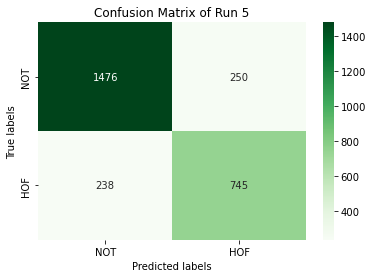

In [7]:
# do the 5-Fold Cross Validation (Datasets are splitted already and stored in a S3 Bucket)
for train_index in train_test_number:
    print(f"Fold Number: {train_index}")
    # Read data
    with s3.open(f"{bucket_name}/KFOLD{train_index}/{train_file_name}",'r') as file:
        data = pd.read_csv(file)
    with s3.open(f"{bucket_name}/KFOLD{train_index}/{test_file_name}",'r') as file:
        test_data = pd.read_csv(file)
    data = data[["Text", "majority_vote"]]
    test_data = test_data[["Text", "majority_vote"]]
    data.rename(columns={'Text': 'text', 'majority_vote': 'labels'}, inplace=True)
    test_data.rename(columns={'Text': 'text', 'majority_vote': 'labels'}, inplace=True)
    print(test_data.head(2))
    print(len(data))
    print(len(test_data))
    print(f"Train Verteilung: {data.labels.value_counts()}")
    print(f"Test Verteilung: {test_data.labels.value_counts()}")

    # Define pretrained tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # ----- 1. Preprocess data -----#
    # Preprocess data
    X = list(data["text"])
    y = list(data["labels"])
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=11)
    X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
    X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

    # Create torch dataset
    class Dataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels=None):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            if self.labels:
                item["labels"] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.encodings["input_ids"])

    train_dataset = Dataset(X_train_tokenized, y_train)
    val_dataset = Dataset(X_val_tokenized, y_val)
    
    # ----- 2. Fine-tune pretrained model -----#
    
    # Define Trainer parameters
    def compute_metrics(p):
        pred, labels = p
        pred = np.argmax(pred, axis=1)

        accuracy = accuracy_score(y_true=labels, y_pred=pred)
        recall = recall_score(y_true=labels, y_pred=pred,average="macro")
        precision = precision_score(y_true=labels, y_pred=pred,average="macro")
        f1 = f1_score(y_true=labels, y_pred=pred,average="macro")

        return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

    args = TrainingArguments(
        report_to="none", # disable wandb
        output_dir=f"res",
        overwrite_output_dir=True,
        evaluation_strategy="epoch",
        eval_steps=50,
        logging_strategy="steps",
        logging_steps=50,
        save_strategy="epoch",
        #save_steps=200,
        learning_rate= learning_rate,
        warmup_steps =  warmup,
        weight_decay = weight_decay,
        per_device_train_batch_size= batch_size,
        per_device_eval_batch_size= batch_size,
        num_train_epochs= epochs,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    )

    # Train pre-trained model
    trainer.train()
    
    print("Saving Best Model")
    trainer.save_model(f"{ansatz}_best_model")

    # ----- 3. Predict -----#
    # Load test data
    X_test = list(test_data["text"])
    X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

    # Create torch dataset
    test_dataset = Dataset(X_test_tokenized)

    # Load trained model
    #best_ckpt_path = trainer.state.best_model_checkpoint
    #model_path = "gbert_res/checkpoint-200"
    model = AutoModelForSequenceClassification.from_pretrained(f"{ansatz}_best_model", num_labels=2)

    # Define test trainer
    test_trainer = Trainer(model)
    #test_trainer = trainer

    # Make prediction
    raw_pred, _, _ = test_trainer.predict(test_dataset)

    # Preprocess raw predictions
    y_pred = np.argmax(raw_pred, axis=1)

    from sklearn.metrics import f1_score

    test_list = test_data["labels"].tolist()
    test_list = np.array(test_list)

    # Compute Evaluation Metrics
    f = f1_multiclass(test_list, y_pred)
    p = p_multiclass(test_list, y_pred)
    r = recall_multiclass(test_list, y_pred)
    a = accuracy_score(test_list, y_pred)
    ba = balanced_accuracy_score(test_list, y_pred)
    prs = precision_recall_fscore_support(test_list, y_pred)
    m = matthews_corrcoef(test_list,y_pred)

    results = {}
    results["acc"] = a
    results["f1"] = f
    results["precision"] = p
    results["recall"] = r
    results["bal_acc"] = ba
    results["prfs"] = prs
    results["mcc"] = m

    prepare_results(results)
    result_df = dict_to_df(results)
    result_df.to_csv(f"{ansatz}{train_index}.csv")
    print(result_df)
    class_rep = classification_report(test_list, y_pred,target_names=["HOF", "NOT"])
    cm = confusion_matrix(test_list, y_pred,)
    ax = plt.subplot()
    cm_plot = sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Greens');
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(F'Confusion Matrix of Run {train_index}') 
    ax.xaxis.set_ticklabels(['NOT', 'HOF'])
    ax.yaxis.set_ticklabels(['NOT', 'HOF']);
    cm_plot.figure.savefig(f"{ansatz}_best_model/confusion_matrix_{train_index}.png")
    print(f"Finished Fold Number: {train_index}")

In [8]:
# Compute Average Scores out of the results of all Folds
res = kfold_evaluation(ansatz)
res.to_csv(f"KFOLD_PREPROCESS_Model_Results/{ansatz}.csv")
res

,Metrics,Overall Results
0,acc,0.816980
1,bal_acc,0.800744
2,mcc,0.604157
3,f1_macro,0.801607
4,f1_micro,0.816980
5,f1_weighted,0.816672
6,precision_macro,0.803471
7,precision_micro,0.816980
8,precision_weighted,0.817236
9,recall_macro,0.800744


Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.9/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/opt/conda/lib/python3.9/site-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/opt/conda/lib/python3.9/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'


# Speicherplatz verwalten

In [1]:
import nvidia_smi

nvidia_smi.nvmlInit()

handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
# card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)

nvidia_smi.nvmlShutdown()

Total memory: 11811160064
Free memory: 11719409664
Used memory: 91750400


In [14]:
# Clear Cuda Cache, if it is out of memory
import gc
gc.collect()
torch.cuda.empty_cache()